# Object and scene detection using Amazon Rekognition

***
This notebook provides a walkthrough of [object detection API](https://docs.aws.amazon.com/rekognition/latest/dg/labels.html) in Amazon Rekognition to identify objects.
***

# Initialize stuff

In [36]:
# Initialise Notebook
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont, ExifTags, ImageColor
import time
import os
import io

In [5]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = "us-east-1"

In [6]:
# Init clients
rekognition = boto3.client('rekognition')
s3 = boto3.client('s3')

In [90]:
# S3 bucket that contains sample images and videos

# We are providing sample images and videos in this bucket so
# you do not have to manually download/upload test images and videos.

bucketName = "aws-rek-immersionday-" + awsRegion
bucketName = "aws-recognition-api-indonesia-samples"

In [70]:
# Create temporary directory
# This directory is not needed to call Rekognition APIs.
# We will only use this directory to download images from S3 bucket and draw bounding boxes

!mkdir m1tmp
tempFolder = 'm1tmp/'

mkdir: cannot create directory ‘m1tmp’: File exists


# Detect objects in image
***

In [71]:
#imageName = "media/object-detection/cars.png"
imageName = "image/jakarta.jpg"

In [72]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

#### Call Rekognition to detect objects in the image

In [73]:
# Call Amazon Rekognition to detect objects in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html

detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

#### Review the raw JSON reponse from Rekognition

In [43]:
# Show JSON response returned by Rekognition Labels API (Object Detection)
# In the JSON response below, you will see Label, detected instances, confidence score and additional information.

display(detectLabelsResponse)

{'Labels': [{'Name': 'Road',
   'Confidence': 99.87413024902344,
   'Instances': [],
   'Parents': []},
  {'Name': 'Freeway',
   'Confidence': 98.77552032470703,
   'Instances': [],
   'Parents': [{'Name': 'Road'}]},
  {'Name': 'Highway',
   'Confidence': 98.63104248046875,
   'Instances': [],
   'Parents': [{'Name': 'Freeway'}, {'Name': 'Road'}]},
  {'Name': 'Car',
   'Confidence': 97.49855041503906,
   'Instances': [{'BoundingBox': {'Width': 0.053639769554138184,
      'Height': 0.0738852247595787,
      'Left': 0.3916373550891876,
      'Top': 0.8156924247741699},
     'Confidence': 97.49855041503906},
    {'BoundingBox': {'Width': 0.029441261664032936,
      'Height': 0.045136068016290665,
      'Left': 0.42846131324768066,
      'Top': 0.7033207416534424},
     'Confidence': 97.20987701416016},
    {'BoundingBox': {'Width': 0.028389643877744675,
      'Height': 0.04249034821987152,
      'Left': 0.49013552069664,
      'Top': 0.7109653353691101},
     'Confidence': 94.313926696777

#### Based on BoundingBox data that we get from Rekognition JSON Response, we can draw bounding boxes on our image

In [53]:
s3_connection = boto3.resource('s3')
s3_object = s3_connection.Object(bucketName,imageName)
s3_response = s3_object.get()

stream = io.BytesIO(s3_response['Body'].read())
image=Image.open(stream)

In [54]:
imgWidth, imgHeight = image.size  
draw = ImageDraw.Draw(image) 
image.show()

In [58]:
# We are going to search for car labels here
cars = []
for objectLabel in detectLabelsResponse["Labels"]:
    if objectLabel["Name"]=="Car":
        cars = objectLabel["Instances"]
        break

In [60]:
# Draw bounding boxes on cars in the image
for car in cars:
    box = car['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']
    
    points = (
        (left,top),
        (left + width, top),
        (left + width, top + height),
        (left , top + height),
        (left, top)
    )
    draw.line(points, fill='#00d400', width=2)

    # Alternatively can draw rectangle. However you can't set line width.
    #draw.rectangle([left,top, left + width, top + height], outline='#00d400') 

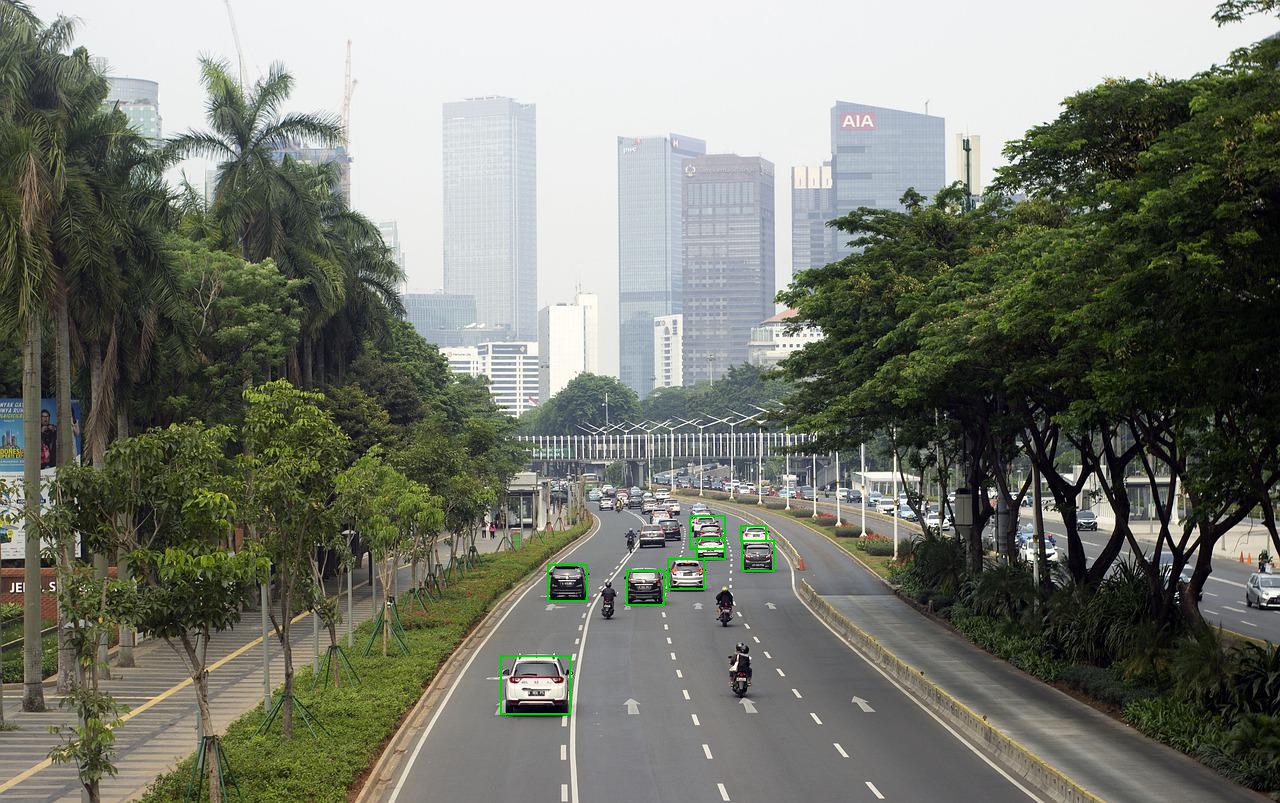

In [61]:
#Display the image with bounding boxes
display(image)

### Bring your own image

- Upload your image to the static folder in this directory


In [105]:
imagePath = "./static/adventure.jpg"
with open(imagePath, 'rb') as image:
    response = rekognition.detect_labels(Image={'Bytes': image.read()})

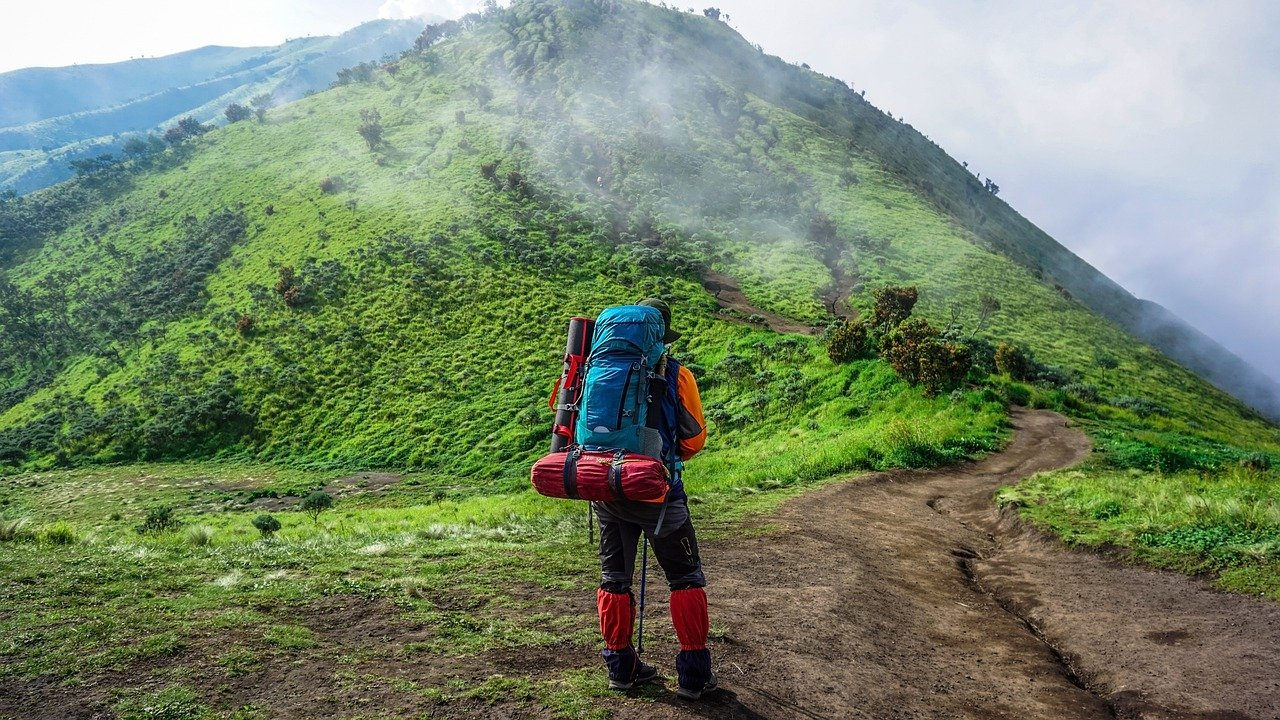

In [106]:
img = Image.open(imagePath)
display(img)

In [107]:
#Display rekognition JSON Response
display(response)

{'Labels': [{'Name': 'Backpack',
   'Confidence': 99.13514709472656,
   'Instances': [{'BoundingBox': {'Width': 0.11872272193431854,
      'Height': 0.2935744524002075,
      'Left': 0.4248487055301666,
      'Top': 0.42514538764953613},
     'Confidence': 71.2146987915039}],
   'Parents': [{'Name': 'Bag'}]},
  {'Name': 'Bag',
   'Confidence': 99.13514709472656,
   'Instances': [],
   'Parents': []},
  {'Name': 'Person',
   'Confidence': 97.16796875,
   'Instances': [{'BoundingBox': {'Width': 0.1252240240573883,
      'Height': 0.5487520098686218,
      'Left': 0.4354937672615051,
      'Top': 0.4158356487751007},
     'Confidence': 97.16796875}],
   'Parents': []},
  {'Name': 'Human', 'Confidence': 97.16796875, 'Instances': [], 'Parents': []},
  {'Name': 'Outdoors',
   'Confidence': 95.3033218383789,
   'Instances': [],
   'Parents': []},
  {'Name': 'Nature',
   'Confidence': 79.36300659179688,
   'Instances': [],
   'Parents': []},
  {'Name': 'Hiking',
   'Confidence': 72.01676177978

# Recognize objects in video
 Object recognition in video is an async operation. 
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html. 

- First we start a label detection job which returns a Job Id.
- We can then call `get_label_detection` to get the job status and after job is complete, we can get object metadata.
- In production use cases, you would usually use StepFunction or SNS topic to get notified when job is complete.
***

In [78]:
videoName = "video/video.mp4"
# awsRegion = "us-east-1"
# bucketName = "aws-rek-immersionday-" + awsRegion

In [79]:
startLabelDetection = rekognition.start_label_detection(
    Video={
        'S3Object': {
            'Bucket': bucketName,
            'Name': videoName,
        }
    },
)

#### Call Rekognition to start a job for object detection

In [80]:
# Start video label recognition job
startLabelDetection = rekognition.start_label_detection(
    Video={
        'S3Object': {
            'Bucket': bucketName,
            'Name': videoName,
        }
    },
)

labelsJobId = startLabelDetection['JobId']
display("Job Id: {0}".format(labelsJobId))

'Job Id: 066d1b6af6e7306145cfe5820af8e3a30f1ea827a79115425be62bd5108cf475'

### Additional (Optional) Request Attributes

ClientRequestTokenL
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html#rekognition-StartLabelDetection-request-ClientRequestToken

JobTag:
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html#rekognition-StartLabelDetection-request-JobTag

MinConfidence:
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html#rekognition-StartLabelDetection-request-MinConfidence

NotificationChannel:
https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html#rekognition-StartLabelDetection-request-NotificationChannel


#### Wait for object detection job to complete

In [81]:
# Wait for object detection job to complete
# In production use cases, you would usually use StepFunction or SNS topic to get notified when job is complete.
getObjectDetection = rekognition.get_label_detection(
    JobId=labelsJobId,
    SortBy='TIMESTAMP'
)

while(getObjectDetection['JobStatus'] == 'IN_PROGRESS'):
    time.sleep(5)
    print('.', end='')
 
    getObjectDetection = rekognition.get_label_detection(
    JobId=labelsJobId,
    SortBy='TIMESTAMP')
    
display(getObjectDetection['JobStatus'])

....

'SUCCEEDED'

#### Review raw JSON reponse from Rekognition

In [82]:
# Show JSON response returned by Rekognition Object Detection API
# In the JSON response below, you will see list of detected objects and activities.
# For each detected object, you will see information like Timestamp

display(getObjectDetection)

{'JobStatus': 'SUCCEEDED',
 'VideoMetadata': {'Codec': 'h264',
  'DurationMillis': 15015,
  'Format': 'QuickTime / MOV',
  'FrameRate': 23.976024627685547,
  'FrameHeight': 720,
  'FrameWidth': 1280,
  'ColorRange': 'LIMITED'},
 'Labels': [{'Timestamp': 0,
   'Label': {'Name': 'Gray',
    'Confidence': 64.35501861572266,
    'Instances': [],
    'Parents': []}},
  {'Timestamp': 458,
   'Label': {'Name': 'Alloy Wheel',
    'Confidence': 79.22071838378906,
    'Instances': [],
    'Parents': [{'Name': 'Spoke'}, {'Name': 'Wheel'}, {'Name': 'Machine'}]}},
  {'Timestamp': 458,
   'Label': {'Name': 'Automobile',
    'Confidence': 86.42240142822266,
    'Instances': [],
    'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]}},
  {'Timestamp': 458,
   'Label': {'Name': 'Car',
    'Confidence': 86.42240142822266,
    'Instances': [{'BoundingBox': {'Width': 0.24835076928138733,
       'Height': 0.1753828227519989,
       'Left': 0.18209482729434967,
       'Top': 0.553619921207428},
  

#### Display names of recognized objects in the video

In [83]:
flaggedObjectsInVideo = ["Car"]

theObjects = {}

# Display timestamps and objects detected at that time
strDetail = "Objects detected in video<br>=======================================<br>"
strOverall = "Objects in the overall video:<br>=======================================<br>"

# Objects detected in each frame
for obj in getObjectDetection['Labels']:
    ts = obj ["Timestamp"]
    cconfidence = obj['Label']["Confidence"]
    oname = obj['Label']["Name"]
    
    if(oname in flaggedObjectsInVideo):
        print("Found flagged object at {} ms: {} (Confidence: {})".format(ts, oname, round(cconfidence,2)))
    
    strDetail = strDetail + "At {} ms: {} (Confidence: {})<br>".format(ts, oname, round(cconfidence,2))
    if oname in theObjects:
        cojb = theObjects[oname]
        theObjects[oname] = {"Name" : oname, "Count": 1+cojb["Count"]}
    else:
        theObjects[oname] = {"Name" : oname, "Count": 1}

# Unique objects detected in video
for theObject in theObjects:
    strOverall = strOverall + "Name: {}, Count: {}<br>".format(theObject, theObjects[theObject]["Count"])

# Display results
display(HTML(strOverall))

Found flagged object at 458 ms: Car (Confidence: 86.42)
Found flagged object at 959 ms: Car (Confidence: 99.9)
Found flagged object at 1459 ms: Car (Confidence: 99.9)
Found flagged object at 1960 ms: Car (Confidence: 80.22)
Found flagged object at 2961 ms: Car (Confidence: 50.02)
Found flagged object at 3461 ms: Car (Confidence: 50.46)
Found flagged object at 4963 ms: Car (Confidence: 70.57)
Found flagged object at 5463 ms: Car (Confidence: 92.8)
Found flagged object at 5964 ms: Car (Confidence: 99.88)
Found flagged object at 6464 ms: Car (Confidence: 99.87)
Found flagged object at 6965 ms: Car (Confidence: 92.65)
Found flagged object at 7465 ms: Car (Confidence: 72.39)
Found flagged object at 7966 ms: Car (Confidence: 70.53)
Found flagged object at 8466 ms: Car (Confidence: 69.46)
Found flagged object at 8967 ms: Car (Confidence: 65.92)
Found flagged object at 9467 ms: Car (Confidence: 72.18)
Found flagged object at 9968 ms: Car (Confidence: 87.49)
Found flagged object at 10468 ms: Ca

#### Show video in the player

In [84]:
# Show video in a player

s3VideoUrl = s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': videoName})

videoTag = "<video controls='controls' autoplay width='640' height='360' name='Video' src='{0}'></video>".format(s3VideoUrl)

videoui = "<table><tr><td style='vertical-align: top'>{}</td></tr></table>".format(videoTag)

display(HTML(videoui))

In [85]:
listui = "<table><tr><td style='vertical-align: top'>{}</td></tr></table>".format(strDetail)
display(HTML(listui))

## Worker Safety with Amazon Rekognition
***
You can use Amazon Rekognition to detect if certain objects are not present in the image or video. For example you can perform worker safety audit by revieweing images/video of a construction site  and detecting if there are any workers without safety hat.

In [108]:
imageName = "image/hat-detection.png"

In [109]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

In [110]:
# Call Amazon Rekognition to detect objects in the image

detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

In [111]:
# Display Rekognition response
display(detectLabelsResponse)

{'Labels': [{'Name': 'Person',
   'Confidence': 99.74844360351562,
   'Instances': [{'BoundingBox': {'Width': 0.4660300314426422,
      'Height': 0.9347332119941711,
      'Left': 0.37392541766166687,
      'Top': 0.02074061892926693},
     'Confidence': 99.74844360351562},
    {'BoundingBox': {'Width': 0.1087615117430687,
      'Height': 0.19702020287513733,
      'Left': 0.8208402395248413,
      'Top': 0.027133075520396233},
     'Confidence': 99.04203033447266}],
   'Parents': []},
  {'Name': 'Human',
   'Confidence': 99.74844360351562,
   'Instances': [],
   'Parents': []},
  {'Name': 'Clothing',
   'Confidence': 88.4556655883789,
   'Instances': [],
   'Parents': []},
  {'Name': 'Apparel',
   'Confidence': 88.4556655883789,
   'Instances': [],
   'Parents': []},
  {'Name': 'Helmet',
   'Confidence': 85.29509735107422,
   'Instances': [{'BoundingBox': {'Width': 0.13620616495609283,
      'Height': 0.15723176300525665,
      'Left': 0.5521215200424194,
      'Top': 0.01142939738929

In [112]:
# Define a function that will display image with bounded boxes around recognized objects
# We will call this function in next step
  
def drawBoundingBoxes (sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255,255,255),(255,255,255),(76,182,252),(52,194,123))
    
    # Download image locally
    imageLocation = tempFolder+os.path.basename(sourceImage)
    s3.download_file(bucketName, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        draw.text((x1,y1),box[0],colors[col])
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
        imageFormat = 'JPEG'

    bbImage.save(imageLocation,format=imageFormat)

    display(bbImage)

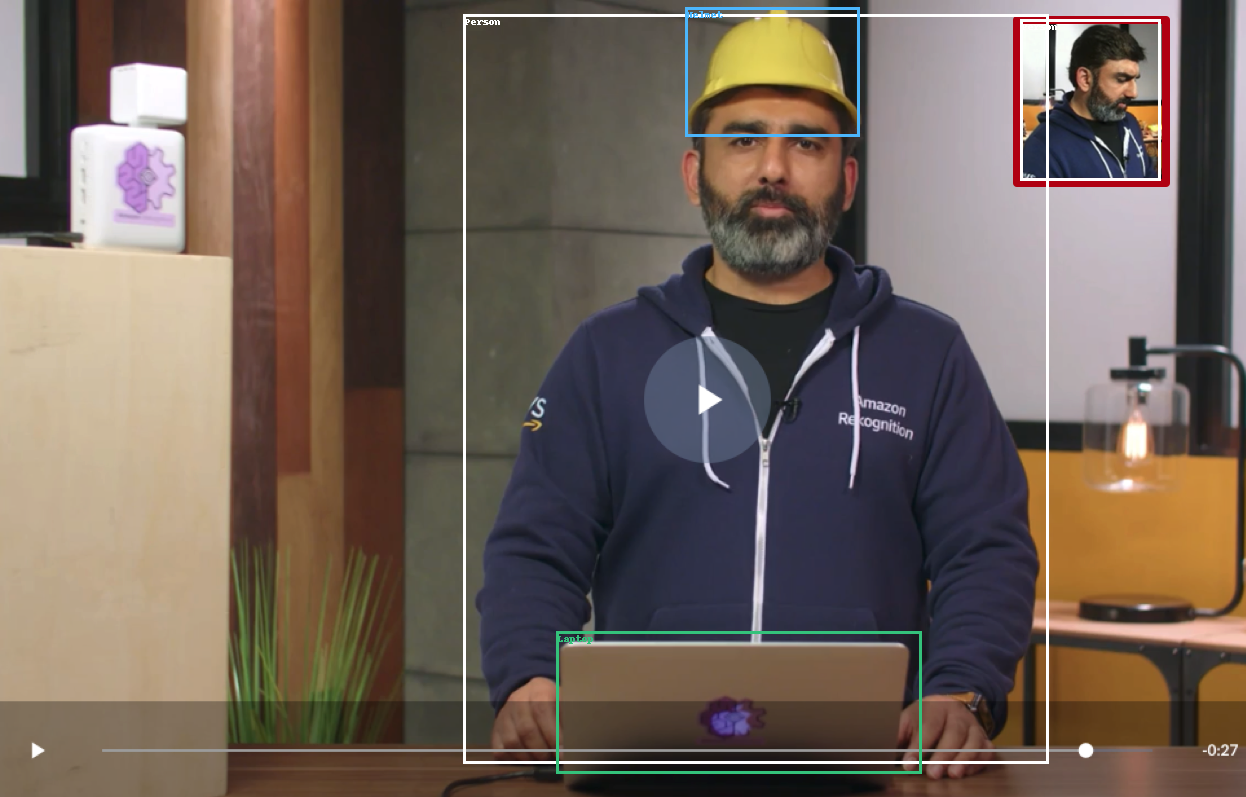

In [113]:
# Show image and bounded boxes around detected objects
boxes = []
objects = detectLabelsResponse['Labels']
for obj in objects:
    for einstance in obj["Instances"]:
        boxes.append ((obj['Name'], einstance['BoundingBox']))
    
drawBoundingBoxes(imageName, boxes)


In [114]:
def matchPersonsAndHats(personsList, hardhatsList):

    persons = []
    hardhats = []
    personsWithHats = []

    for person in personsList:
        persons.append(person)
    for hardhat in hardhatsList:
        hardhats.append(hardhat)

    h = 0
    matched = 0
    totalHats = len(hardhats)
    while(h < totalHats):
        hardhat = hardhats[h-matched]
        totalPersons = len(persons)
        p = 0
        while(p < totalPersons):
            person = persons[p]
            if(not (hardhat['BoundingBoxCoordinates']['x2'] < person['BoundingBoxCoordinates']['x1']
                or hardhat['BoundingBoxCoordinates']['x1'] > person['BoundingBoxCoordinates']['x2']
                or hardhat['BoundingBoxCoordinates']['y4'] < person['BoundingBoxCoordinates']['y1']
                    or hardhat['BoundingBoxCoordinates']['y1'] > person['BoundingBoxCoordinates']['y4']
                )):

                personsWithHats.append({'Person' : person, 'Hardhat' : hardhat})

                del persons[p]
                del hardhats[h - matched]

                matched = matched + 1

                break
            p = p + 1
        h = h + 1

    return (personsWithHats, persons, hardhats)

def getBoundingBoxCoordinates(boundingBox, imageWidth, imageHeight):
    x1 = 0
    y1 = 0
    x2 = 0
    y2 = 0
    x3 = 0
    y3 = 0
    x4 = 0
    y4 = 0

    boxWidth = boundingBox['Width']*imageWidth
    boxHeight = boundingBox['Height']*imageHeight

    x1 = boundingBox['Left']*imageWidth
    y1 = boundingBox['Top']*imageWidth

    x2 = x1 + boxWidth
    y2 = y1

    x3 = x2
    y3 = y1 + boxHeight

    x4 = x1
    y4 = y3

    return({'x1': x1, 'y1' : y1, 'x2' : x2, 'y2' : y2, 'x3' : x3, 'y3' : y3, 'x4' : x4, 'y4' : y4})

def getPersonsAndHardhats(labelsResponse, imageWidth, imageHeight):

    persons = []
    hardhats = []

    for label in labelsResponse['Labels']:
        if label['Name'] == 'Person' and 'Instances' in label:
            for person in label['Instances']:
                    persons.append({'BoundingBox' : person['BoundingBox'], 'BoundingBoxCoordinates' : getBoundingBoxCoordinates(person['BoundingBox'], imageWidth, imageHeight), 'Confidence' : person['Confidence']})
        elif ((label['Name'] == 'Hardhat' or label['Name'] == 'Helmet') and 'Instances' in label):
            for hardhat in label['Instances']:
                hardhats.append({'BoundingBox' : hardhat['BoundingBox'], 'BoundingBoxCoordinates' : getBoundingBoxCoordinates(hardhat['BoundingBox'], imageWidth, imageHeight), 'Confidence' : hardhat['Confidence']})

    return (persons, hardhats)

In [115]:
s3Resource = boto3.resource('s3')
bucket = s3Resource.Bucket(bucketName)
iojb = bucket.Object(imageName)
response = iojb.get()
file_stream = response['Body']
im = Image.open(file_stream)
imageWidth, imageHeight = im.size

In [116]:
persons, hardhats = getPersonsAndHardhats(detectLabelsResponse, imageWidth, imageHeight)

personsWithHats, personsWithoutHats, hatsWihoutPerson = matchPersonsAndHats(persons, hardhats)

personsWithHatsCount = len(personsWithHats)
personsWithoutHatsCount = len(personsWithoutHats)
hatsWihoutPersonCount = len(hatsWihoutPerson)

outputMessage = "Person(s): {}".format(personsWithHatsCount+personsWithoutHatsCount)
outputMessage = outputMessage + "\nPerson(s) With Safety Hat: {}\nPerson(s) Without Safety Hat: {}".format(personsWithHatsCount, personsWithoutHatsCount)
print(outputMessage)

Person(s): 2
Person(s) With Safety Hat: 1
Person(s) Without Safety Hat: 1


### Learn more about building an end to end worker safety app
To learn on how to build an end to end worker safety app, learn more at https://github.com/aws-samples/aws-deeplens-worker-safety-project

***
### References
- https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_StartLabelDetection.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_GetLabelDetection.html

***

You have successfully used Amazon Rekognition to identify specific objects in images and videos. In the next module,nyou will learn how to recognize explicit, suggestive or violent content in the images and videos.